<a href="https://colab.research.google.com/github/YoshifumiMiyagi/EDV_3D/blob/main/PECARN_Group_1_hirose_model_KerasClassifier_BalancedBaggingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
SEED = 42
threshold = 0.15
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# CSVファイルを読み込む
df = pd.read_csv('/content/TBI PUD 10-08-2013.csv')
# 使用された説明変数とCTスキャンの必要性を示す目的変数をリストにする

variables_of_interest = [
    'AgeTwoPlus',         # 年齢
    'High_impact_InjSev', # 外傷の重症度
    'LOCSeparate',        # 意識喪失の履歴
    'LocLen',             # 意識喪失の持続時間
    'HA_verb',            # 頭痛の有無
    'HASeverity',         # 頭痛の重症度
    'Vomit',              # 嘔吐の履歴
    'VomitNbr',           # 嘔吐の回数
    'ActNorm',            # 保護者の観察
    'GCSTotal',           # GCSスコア
    'AMS',                # 精神状態の変化
    'SFxBas',             # 基底頭蓋骨骨折の兆候
    'SFxPalp',            # 触知可能な頭蓋骨骨折
    'Hema',               # 頭皮血腫
    'HemaLoc',            # 頭皮血腫の位置
#    'HospHeadPosCT',      # 目的変数（CTスキャンと2日以上の入院の必要性）
    'PosCT'               # 目的変数（CTスキャンの必要性）
]
# 説明変数と目的変数のみを抽出
df_selected = df[variables_of_interest]
# 92（該当なし）を除く。
dat = df_selected[df_selected['PosCT'] != 92]
dat.shape

(15899, 16)

In [2]:
# 使用する特徴量と目的変数のリスト
features = [
    'AgeTwoPlus', 'High_impact_InjSev', 'LOCSeparate', 'LocLen', 'HA_verb',
    'HASeverity', 'Vomit', 'VomitNbr', 'ActNorm', 'GCSTotal', 'AMS',
    'SFxBas', 'SFxPalp', 'Hema', 'HemaLoc'
]
target = 'PosCT'

# 特徴量と目的変数の抽出
dat=dat[dat[target] != 92]
X = dat[features]
y = dat[target]

# 欠損値の処理
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 訓練データとテストデータの分割
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint

modelCheckpoint = ModelCheckpoint(filepath = 'model_0.keras',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min')

In [4]:
import os
import random

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=32, activation="relu", input_shape=(x_train.shape[-1],) ),
        tf.keras.layers.Dense(units=16, activation="relu"),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

learning_rate = 0.01

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="binary_crossentropy",
              metrics=['auc']
             )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
history = model.fit(x_train, y_train,
          epochs=20,
          batch_size=100,
          validation_data=(x_test, y_test),
          callbacks=[modelCheckpoint],
          verbose=-1)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.20022, saving model to model_0.keras
Epoch 2/20

Epoch 2: val_loss did not improve from 0.20022
Epoch 3/20

Epoch 3: val_loss did not improve from 0.20022
Epoch 4/20

Epoch 4: val_loss did not improve from 0.20022
Epoch 5/20

Epoch 5: val_loss improved from 0.20022 to 0.19964, saving model to model_0.keras
Epoch 6/20

Epoch 6: val_loss did not improve from 0.19964
Epoch 7/20

Epoch 7: val_loss did not improve from 0.19964
Epoch 8/20

Epoch 8: val_loss did not improve from 0.19964
Epoch 9/20

Epoch 9: val_loss did not improve from 0.19964
Epoch 10/20

Epoch 10: val_loss did not improve from 0.19964
Epoch 11/20

Epoch 11: val_loss did not improve from 0.19964
Epoch 12/20

Epoch 12: val_loss did not improve from 0.19964
Epoch 13/20

Epoch 13: val_loss did not improve from 0.19964
Epoch 14/20

Epoch 14: val_loss did not improve from 0.19964
Epoch 15/20

Epoch 15: val_loss did not improve from 0.19964
Epoch 16/20

Epoch 16: val_loss did n

In [7]:
# テストデータでの予測
model = tf.keras.models.load_model('/content/model_0.keras')
y_pred_prob_NN = model.predict(x_test)
# 予測値を二値化
y_pred = (y_pred_prob_NN > threshold).astype(int)

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# AUCの計算
auc = roc_auc_score(y_test, y_pred_prob_NN)
print(f"AUC: {auc}")
# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", Precision)
print("f1:", f1)
print("accuracy:", accuracy)
# 感度 (Recall) の計算
sensitivity = tp / (tp + fn)
print(f"感度 (Recall): {sensitivity}")
# 特異度 (Specificity) の計算
specificity = tn / (tn + fp)
print(f"特異度 (Specificity): {specificity}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
AUC: 0.8143198231392778
Precision: 0.3628048780487805
f1: 0.4265232974910394
accuracy: 0.89937106918239
感度 (Recall): 0.5173913043478261
特異度 (Specificity): 0.9291525423728814


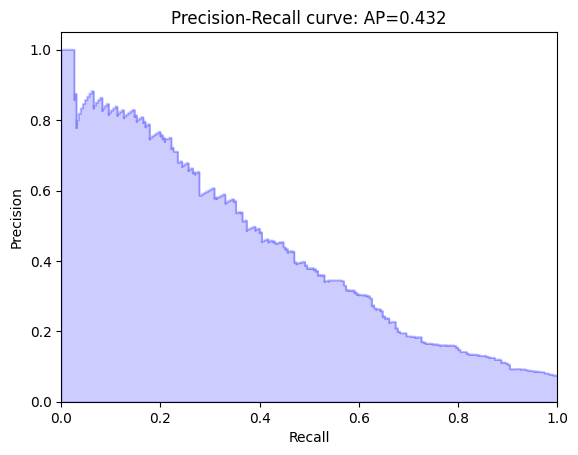

In [8]:
# Precision-Recall曲線の計算
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_NN)
average_precision = average_precision_score(y_test, y_pred_prob_NN)

# Precision-Recall曲線のプロット
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.3f}'.format(average_precision))
plt.show()

# KerasClassfier

In [9]:
!pip install scikeras

In [22]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from imblearn.ensemble import BalancedBaggingClassifier

keras_clf = KerasClassifier(model, epochs=10)
balanced_bagging_clf = BalancedBaggingClassifier(estimator=keras_clf, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False,
                                   oob_score=False, warm_start=False, sampling_strategy='auto', replacement=False, n_jobs=None, verbose=0, sampler=None, random_state=SEED
)

# モデルの学習
balanced_bagging_clf.fit(x_train, y_train)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - auc: 0.7953 - loss: 0.5672
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.8357 - loss: 0.4834
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.8434 - loss: 0.4720
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.8526 - loss: 0.4593
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8607 - loss: 0.4482
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.8656 - loss: 0.4402
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.8715 - loss: 0.4337
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.8744 - loss: 0.4295
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.8843 - loss: 0.4137
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.8877 - loss: 0.4074
Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - auc: 0.7561 - loss: 0.6456
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.8162 - loss: 0.5175
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

BalancedBaggingClassifier(estimator=KerasClassifier(epochs=10, model=<Sequential name=sequential, built=True>),
                          random_state=42, replacement=True)

In [20]:
y_pred_prob_NN2 = balanced_bagging_clf.predict_proba(x_test)
# 予測値を二値化

y_pred = (y_pred_prob_NN2[:,1] > threshold).astype(int)
# AUCの計算
auc = roc_auc_score(y_test, y_pred_prob_NN2[:,1])
print(f"AUC: {auc}")
# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", Precision)
print("f1:", f1)
print("accuracy:", accuracy)
# 感度 (Recall) の計算
sensitivity = tp / (tp + fn)
print(f"感度 (Recall): {sensitivity}")
# 特異度 (Specificity) の計算
specificity = tn / (tn + fp)
print(f"特異度 (Specificity): {specificity}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.812608695652174
Precision: 0.08906059373729158
f1: 0.1628858311640015
accuracy: 0.2921383647798742
感度 (Recall): 0.9521739130434783
特異度 (Specificity): 0.24067796610169492


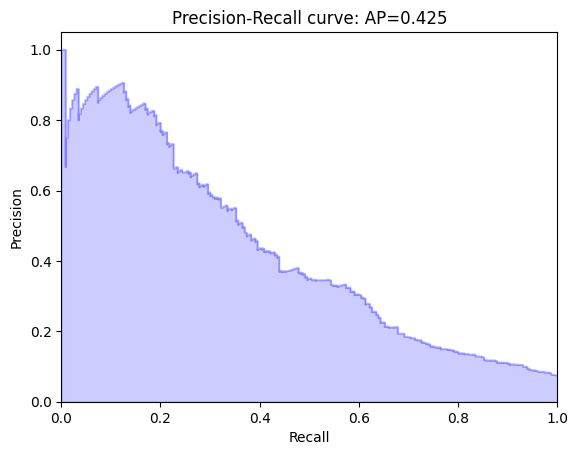

In [21]:
# Precision-Recall曲線の計算
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_NN2[:,1])
average_precision = average_precision_score(y_test, y_pred_prob_NN2[:,1])

# Precision-Recall曲線のプロット
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.3f}'.format(average_precision))
plt.show()